# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from collections import Counter

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == ">50K"].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == "<=50K"].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k)/n_records * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

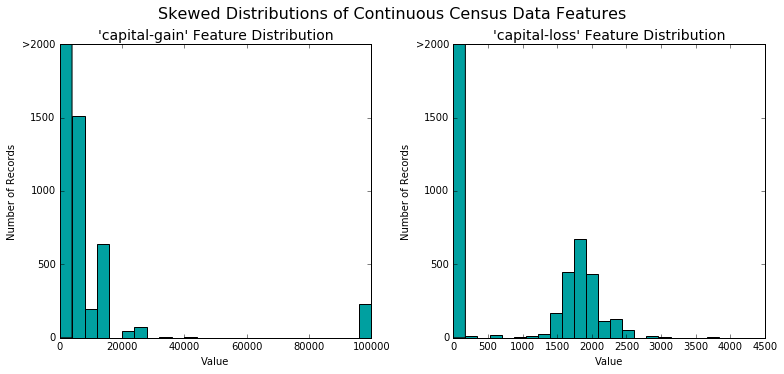

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

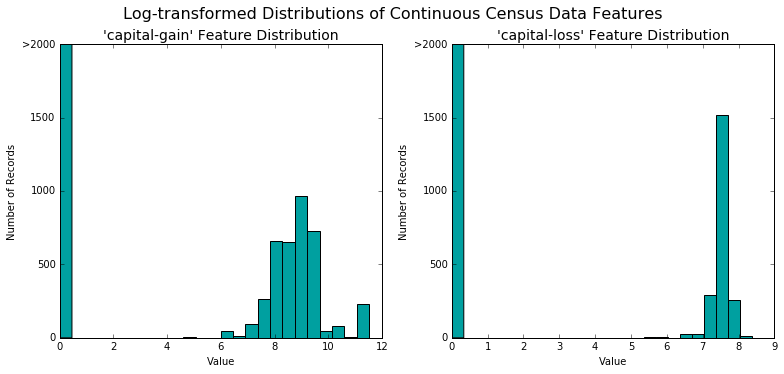

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(data=features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = pd.get_dummies(data=income_raw)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [35]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])



Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [36]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = float(TP[1])/(FP[1] + TP[1]) * 100
recall = 1.0
precision = float(TP[1])/(FP[1] + TP[1])

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
beta = 0.5
fscore = ((1 + pow(beta,2)) * (precision * recall) / ((pow(beta,2) * precision) + recall))

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 24.7844, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

Answer: Although, more classification models from this list can be put to use for this project, I have selected Decision Trees, Ensemble Methods and SVM.

Decsion Trees:
1. One of the ways, Decision Trees (DT) can be used is in business management. Many companies have their own dataset which they can use to enhance their customer support. DT have been in the past applied to customer relationships is to investigate how individuals access online services.This would allow businesses to recommend their product to clients which the client migght be interested in. (Resource :http://what-when-how.com/artificial-intelligence/decision-tree-applications-for-data-modelling-artificial-intelligence/)
2. DT algorithms are easy to interpret, visualize and understand. DTs require little effort for data preparation. DTs inherently do feature selection due to its policy of information gain. Any non-linear between parameters does not affect the performance of the classifier.DTs perform well when there are large datasets. (Reference: https://medium.com/towards-data-science/decision-trees-in-machine-learning-641b9c4e8052)
3. It can lead to a classification that overfits the training data. They are supceptable to small variation in data. Due to this, even a small variance can lead to a different tree. DT sometimes create biased trees if some classes dominate. Greedy algorithms cannot guarantee to return the globally optimal decision tree.It is possible that it can prune out some rare event from the tree itself leading to misclassification when these events occur.(Reference: https://medium.com/towards-data-science/decision-trees-in-machine-learning-641b9c4e8052)
4. Our model has lots of features to choose from. DTs are a good fit for this dataset since, based on our target value, the algorithm selects features that will allow it gain the most amount of information, leading to accurate classification.

Ensemble Method:
1. Ensemble methods find their uses in a wide variety of application ranging from facial recognition to forecasting bankruptcy. This versatility come from the fact that the algorithm uses weak learners to come up with a complex classification that classifies with high level of accuracy.
2. They are made up of simple rules. Takes into consideration that not all datapoints are equally weighted. It provides with a measure of confidence on the prediction that it makes. Error does not rise with increasing number of datapoints. They average out biases and reduce variance. It certainly performs well when we give lots of training data. If we were to plot error v/s training/testing data, normally, error falls with more training data. Similarly, the error falls for some time and then its starts to rise. This is a trend that is generally observed in most of the classifiers. But, when it comes to Emsemble methods, the error does not rise. In fact in reduces with increase in testing data. Also, for example if you have models with high variance (they over-fit your data), then you are likely to benefit from using bagging. If you have biased models, it is better to combine use them with Boosting. (Reference: Some are from the lecture series, https://www.quora.com/How-do-ensemble-methods-work-and-why-are-they-superior-to-individual-models)
3. Ensemle methods contain variety of classifier. These classifier techniques have different application. For instance if we to use a bagging algorithm for a high-variance type of data, it will over-fit data. For a boosting methods, we need larger testing datasets.AdaBoost can be sensitive to noisy data and outliers. Boosting tends to overfit if weak learning uses Artifical Neural Netwok with many layers and nodes. Ensemble mehtods are suspectable to Pink Noise (Uniform Noise). (Reference: Lecture notes and videos.)
4. Our dataset consists of many features. All these features although scaled, still, their effect on prediction may not be linear i.e. they could all be weighted with the effect on the classification. This bias of taking every single feature as equal will lead to errors which can be eliminated using emsemble methods.

SVM:
1. Although a fairly old algorithm, SVM has been used previsouly for facial recognition, bioinformatics, prediction of common diseases etc. This vast application space can be attributed to its ability to stay indifferent to the data by maximizing the margin and operate on data with a large set of features.(Reference: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-10-16)
2. SVM use kernel trick to classify datapoint. These tricks allow us to seperate the data without the hassle of expensive transformation. it has the capability to select those vectors that classify the data most and turn off those vector hypothesis that do not contribute.  SVMs deliver a unique solution. It performs well when, number of features (variables) and number of training data is very large (say millions of features and millions of instances (data)).When sparsity in the problem is very high, i.e., most of the features have zero value. It is the best for document classification problems where sparsity is high and features/instances are also very high. It also performs very well for problems like image classification, genes classsification, drug disambiguation etc. where number of features are high. (Reference: https://core.ac.uk/download/pdf/6302770.pdf)
3. SVMs are susceptible to Noise. They are prone to overfitting the data. Long training time. It is difficult to understand the support vectors. It is difficult to accomodate domain knowledge. For exaome if there are outliers that are present in the data, SVM classification will try to maximize the margin based on these outliers which can lead to poor performance.(Reference:  http://www.cs.uky.edu/~jzhang/CS689/PPDM-Chapter2.pdf)
4. SVM classification is well suited for this application since, it can automatically decide with all features are necessary for classifying whether a certain person earns more than 50K or not. Since are data has lots of features, SVM is well sutied. 






### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [37]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = round(end-start,3)
    print "Training time for {} samples is: {:,.3f}s" .format(sample_size,results['train_time'])
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = round(end-start,3)
    print "Testing time for {} samples is: {:,.3f}s" .format(sample_size,results['train_time'])
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    beta = 0.5
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta)

    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

Training time for 361 samples is: 0.002s
Testing time for 361 samples is: 0.002s
DecisionTreeClassifier trained on 361 samples.
Training time for 3617 samples is: 0.025s
Testing time for 3617 samples is: 0.025s
DecisionTreeClassifier trained on 3617 samples.
Training time for 36177 samples is: 0.398s
Testing time for 36177 samples is: 0.398s
DecisionTreeClassifier trained on 36177 samples.
Training time for 361 samples is: 0.014s
Testing time for 361 samples is: 0.014s
SVC trained on 361 samples.
Training time for 3617 samples is: 1.126s
Testing time for 3617 samples is: 1.126s
SVC trained on 3617 samples.
Training time for 36177 samples is: 138.482s
Testing time for 36177 samples is: 138.482s
SVC trained on 36177 samples.
Training time for 361 samples is: 0.099s
Testing time for 361 samples is: 0.099s
AdaBoostClassifier trained on 361 samples.
Training time for 3617 samples is: 0.242s
Testing time for 3617 samples is: 0.242s
AdaBoostClassifier trained on 3617 samples.
Training time fo

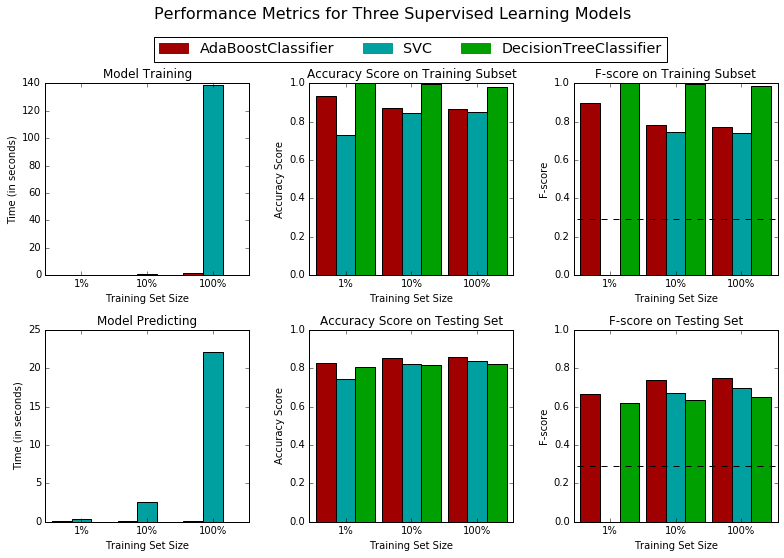

In [38]:
### Converting the data for sklearn use ###
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train['>50K'])
y_test = np.array(y_test['>50K'])

# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier()
clf_B = SVC()
clf_C = AdaBoostClassifier()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = len(y_train[:int(0.1*samples_100)])
samples_1 = len(y_train[:int(0.01*samples_100)])

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

Answer:As per the results obtained, we can divide the evaluation into 3 parts

Accuracy Score:
From above, it can be observed that when increaseing the size of the training set, the accuracy of the test set increases. Except for 1% training dataset, the classifiers can be ranked as 1. AdaBoost, 2. SVM and 3. Decision Trees. Just by looking at this data, one can say that Adaboost is more accurate choice of the three. But, Accuracy is misleading. It is mostly referred as the (# of matches/total sample size). First there is an inherent bias in this metric as it only covers the sample size. Secondly, it does not say anything about the classifier was able to correctly classify it given it was actually true. Therefore, we need to look for a better metric than accuracy. But accuracy does allow us to sieve out Decision Trees. Winner: Adaboost. Loser: Decision Tress

Fbeta Score:
From this data, again, we can rank the classifier based on their score's closeness to 1.0. Adaboost again is at rank 1. followed by SVM and then by Decision Trees. This trend is observed as we increase the training dataset size. Fbeta is a better metric to evaluate the basic performance of the classifier as it takes weighted account of Precision and Recall, allowing us to focus on how confident the classification is. Winner: AdaBoost, loser: Decision Tree

Prediction/Training Time:
The data shows that as we increase the training size, the training time of each clasifier increases. But, the magnitude of increase varies from algorithm to algorithm. Throughtout, SVM takes the most time to train and test with peak time at 127.17s for training. This can be unacceptable to the organization. So, we shall leave out SVM from the discussion. Coming to Adaboost and Decision Tree, both have comparable times but for the sake of ranking them on the basis of least time overall, 1. Decision Tress, 2. AdaBoost and 3. SVM. Winner: Decision Tree, Loser: SVM

After completing this analysis, we can showcase to CharityML that if we were to select Adaboost as the classification model, we will not only have an accurate, precise model (fbeta w/ beta=0.5) but, we will be able to classify reasonably fast. 

Also, these metrics showcase one key aspect that our selection from the start was correct. These models are suitable for this type of data. Had it been some other data, these scores would have indicated poor performance of the classifier in terms of f-score, accuracy and computation time.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

Answer:
Adaboost is an ensemble technique which is based on building a classification model using weak learners. To understand how Adaptive boost or Adaboost works, we need to understand how boosting works. Most of the other techniques have their own algoritms that classify data but, in this technique, instead of using a complex approach, we use simple rules. These simple rules are combined together to give something substantial. So, there are two steps. 1. Learn over a subset of data. Do it a bunch of times and, 2. Combine all the results. In our approach, we pick a subset that allows the classifier to answer some hard problems. Now this hard problem is a relative notion of hardness, to solve a problem, to if we stop computing it at that moment. To combine our rules, we use weighted mean. To better understand the concept, we can replace the use of "rules" with "weak learners". Weak Learners are learner that no matter what the distribution, they will learn it better than just picking up a datapoint based on chance. 

Now comes the fun part. How does the algorithm train and the predict?

Given, we have some data that we split into training and testing data let's assume that this algorithm will run for some "T" timesteps. It will take a distribution of datapoints. Find a "Weak Learner" to classify in that subset with some error. 

Lets say we start with uniform distribution, that is every datapoint is equilikely. Now it make some classifer and make classification. There is a error in the process. This error is then used to constuct the next distribution. Based on how correctly we were able to classifer the previous timestep, we will either make the current distribution bigger or smaller. In other words it will disregard those points that is has already classified correctly and now will put more weigth on datapoints which it has classified incorrectly.This way it will keep on iterating over all the datapoints leading to correctly classifying all of them. 

Now that the model has been able to correctly classify training datapoints, it computes the final classification by weighting on all the "Weak learners" .

Key factors that make this approach sutiable due to its ability to widthstand overfitting even when we increase the data. Only if we were to make the underlying 'weak learners" complex will this setup lead to overfitting. This technique gives us a measure of confidence i.e. it increases as we keep on increaseing training datapoints. Although the ending model may become complex, but the process of iterative learning over weaker algorithm, makes this approach easy.

Hence, Adaboost is the best of the algorithm that we have selected from the set of algo pool of evaluation.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [39]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators' : [x for x in range(500,1550,250)]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=clf,param_grid=parameters,scoring=scorer,n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
start = time()
grid_fit = grid_obj.fit(X_train,y_train)
end = time()
print "Time to train: {:,.3f}s" .format(end-start,3)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Time to train: 370.759s
Unoptimized model
------
Accuracy score on testing data: 0.8607
F-score on testing data: 0.7491

Optimized Model
------
Final accuracy score on the testing data: 0.8706
Final F-score on the testing data: 0.7684


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.2478        |      0.8607       |    0.8706       |
| F-score        |       0.2917        |      0.7491       |    0.7684       |


Answer:
1. The model accuracy and F-score of the optimized model are 86.76% and 0.7448 respectively
2. These scores are slightly better than unoptimized scores
3. On comparing the optimized predictor with our naive predictor, we observe this model is much better than the naive classification model is from the prespective of predicting that everyone earns more than 50K. Also, it shows that not only ore accuracy over the result has increase, our precision and recall have also increased.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

Answer: Capital Gain, Capital Loss, Age, Education and Working-Hours

I would rank then in the following order.
1. Capital Gain
2. Capital Loss
3. Age
4. Working Hours
5. Education

The first two are very clear from the name itself. I can make an argument that a individual who has made a capital gain is more likely than anyone to donate to the cause. Whereas, if an individual has had a capital loss, they are highly unlikely to donate as they don't have surplus capital to give away. 

The remaining 3 are difficult to make case without any statistical data. Therefore I have computed some data to bolster my arguments for my ranking. Please refer the next cell and its STDIO for answers

From my evaluation, if can be seen on average that people who earn more than 50K are comparatively older than their counterparts that earn atmost 50K. This data bolster my argument that people that are towards their their mid 40s and elder, are more settled in their life and have surplus capital to donate when compared with people who are towards their 30s who are still not that well established.

Again, from the cell below, we can see that people on average who work more, tend to earn more than 50K when compared with people who work less. Although, this differencw is not appreciable but, it is good enough to make an assumption for this dataset.

From the data collected, it can be observed that people who earn more than 50K are more likely to have higher education when compared to their peers who earn atmost 50K. This can be seen by the frequency chart I have made for both these groups. From the general trend we can see higher education level does translate to a person's affinity to donate. But, since, the data is scattered, it is possible that the effects of this feature might be less.





In [40]:
# See avergage working-hours #
print "More than 50K age"
display(data[(data['income'] == '>50K')]['age'].describe())
print "Atmost 50K age"
display(data[(data['income'] == '<=50K')]['age'].describe())
print "More than 50K working hours"
display(data[(data['income'] == '>50K')]['hours-per-week'].describe())
print "Atmost 50K working hours"
display(data[(data['income'] == '<=50K')]['hours-per-week'].describe())
### For Education as this field is catagorical ###
print "More than 50K education level"
tmp_list = list(data[data['income'] == '>50K']['education_level'])
freq = Counter(tmp_list)
print freq
print "Atmost 50K education level"
tmp_list = list(data[data['income'] == '<=50K']['education_level'])
freq = Counter(tmp_list)
print freq

More than 50K age


count    11208.000000
mean        44.006067
std         10.340502
min         19.000000
25%         36.000000
50%         43.000000
75%         51.000000
max         90.000000
Name: age, dtype: float64

Atmost 50K age


count    34014.000000
mean        36.749427
std         13.564683
min         17.000000
25%         26.000000
50%         34.000000
75%         46.000000
max         90.000000
Name: age, dtype: float64

More than 50K working hours


count    11208.000000
mean        45.690489
std         10.797764
min          1.000000
25%         40.000000
50%         40.000000
75%         50.000000
max         99.000000
Name: hours-per-week, dtype: float64

Atmost 50K working hours


count    34014.000000
mean        39.372023
std         11.974127
min          1.000000
25%         37.000000
50%         40.000000
75%         40.000000
max         99.000000
Name: hours-per-week, dtype: float64

More than 50K education level
Counter({' Bachelors': 3178, ' HS-grad': 2416, ' Some-college': 1990, ' Masters': 1393, ' Prof-school': 592, ' Assoc-voc': 504, ' Doctorate': 399, ' Assoc-acdm': 398, ' 11th': 89, ' 10th': 82, ' 7th-8th': 55, ' 12th': 43, ' 9th': 38, ' 5th-6th': 22, ' 1st-4th': 8, ' Preschool': 1})
Atmost 50K education level
Counter({' HS-grad': 12367, ' Some-college': 7909, ' Bachelors': 4392, ' 11th': 1530, ' Assoc-voc': 1455, ' 10th': 1141, ' Masters': 1121, ' Assoc-acdm': 1109, ' 7th-8th': 768, ' 9th': 638, ' 12th': 534, ' 5th-6th': 427, ' 1st-4th': 214, ' Prof-school': 193, ' Doctorate': 145, ' Preschool': 71})


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

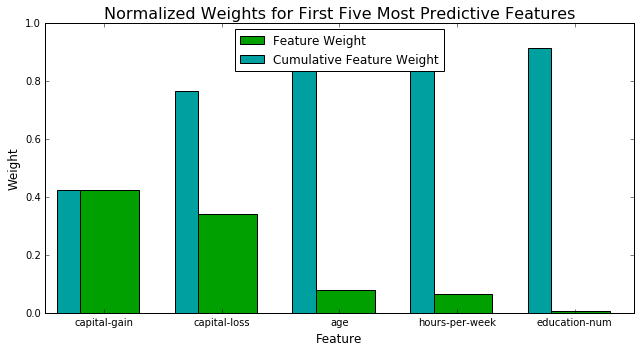

In [41]:
# TODO: Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_

X_train,X_test,y_train,y_test = train_test_split(features_final ,income,test_size=0.2,random_state=42)

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

Answer:
1. These five features are the same as the ones discussed above in question 6
2. These visualization confirm my thought process. Also, this confirms the statistical analysis that I used to bolter my arguments. This also shows that we can prune the dataset to only consider these features. This will speed up the training of the model.
3. My answer were, for the lack of better words "Bang on target"

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [42]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

### Converting the DataFrame to numpy for sklearn usage
X_train_reduced = np.array(X_train_reduced)
X_test_reduced = np.array(X_test_reduced)
y_train = np.array(y_train['>50K'])
y_test = np.array(y_test['>50K'])

# Train on the "best" model found from grid search earlier
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
print "Time to Train: {:,.3f}s" .format(round(end-start,3))
print "----------"
# Make new predictions
start = time()
reduced_predictions = clf.predict(X_test_reduced)
end = time()
print "Time to Test: {:,.3f}s" .format(round(end-start,3))
print "----------"

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Time to Train: 17.908s
----------
Time to Test: 1.303s
----------
Final Model trained on full data
------
Accuracy on testing data: 0.8706
F-score on testing data: 0.7684

Final Model trained on reduced data
------
Accuracy on testing data: 0.8420
F-score on testing data: 0.7193


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

Answer: 
1. The final model with all the features performs slightly well when compared to the reduced feature set. This is very obvious as even though the top 5 features do cover most of the dataset, they still don't make up 100% coverage of the dataset. Therefore, there was bound to be some fall in performance metrics. But overall, the model still performs equally "good" with less time.
2. Yes, if training time is a factor to deploy a classification model, I will use a reduced feature set data. This will allow to make classification faster. Right now the dataset might be small. But when the data grows, if will become impossible to include all the features. Also, if were to go by the "Curse of Dimensionality" if we keep on adding features, we will need exponentially more data to correctly classify it. Therefore by reducting the feature set, we reduce the data requirement to train our classifier. so, its a win-win situation when is comes to using reduced feature dataset (Full dataset: 370.759s, Top_5 features; 17.908s)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.